In [3]:
import tensorflow as tf
from keras.layers import Embedding, GRU, Dense, Dropout, Input, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

MAX_SEQUENCE_LENGTH = 21500

def buildModel():
    # Define model hyperparameters
    VOCAB_SIZE = 1742
    OUTPUT_DIM = 5
    HIDDEN_UNITS_GRU = 64
    HIDDEN_UNITS_DENSE = [128, 64, 1]
    DROPOUT_RATE = 0.2
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    NUM_LABELS = 5 # excluding label 4: 0, 1, 2, 3, 5
    NUM_BRANCHES = NUM_LABELS  # Excluding label 4

    # Define the stem layer (feature extractor)
    inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
    gru_output = GRU(HIDDEN_UNITS_GRU)(embedding)

    # Define the vulnerability branches
    branches = []
    for i in range(NUM_BRANCHES):
        dense1 = Dense(HIDDEN_UNITS_DENSE[0])(gru_output)
        dropout = Dropout(DROPOUT_RATE)(dense1)
        dense2 = Dense(HIDDEN_UNITS_DENSE[1])(dropout)
        dense3 = Dense(HIDDEN_UNITS_DENSE[2], activation='sigmoid', name=f'output_{i}')(dense2)
        branches.append(dense3)

    # # Concatenate the branches and create the model
    # concatenated = Concatenate()(branches)
    model = Model(inputs=inputs, outputs=branches)

    label_metrics = {}
    for i in range(NUM_BRANCHES):
        label_metrics[f'output_{i}'] = 'accuracy'

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=BinaryCrossentropy(from_logits=False),
                  metrics=label_metrics)

    return model

model = buildModel()
num_outputs = len(model.outputs)
print("Number of outputs:", num_outputs)
print('model output names:')
print(model.output_names)
# Print the model summary
# model.summary()

Number of outputs: 5
model output names:
['output_0', 'output_1', 'output_2', 'output_3', 'output_4']


In [4]:
from keras.callbacks import Callback

class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.chunk_metrics = []

    def on_epoch_end(self, epoch, logs=None):
        chunk_loss = []
        chunk_accuracy = []

        # Compute loss and accuracy for each output
        for output_name in self.model.output_names:
            loss_key = f'{output_name}_loss'
            accuracy_key = f'{output_name}_accuracy'

            if loss_key in logs:
                chunk_loss.append(logs[loss_key])
            if accuracy_key in logs:
                chunk_accuracy.append(logs[accuracy_key])

        self.chunk_metrics.append({'loss': chunk_loss, 'accuracy': chunk_accuracy})

In [1]:
pip install scikit-learn

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/Practicum/TrainedModel/model_escort_design_1.h5")

In [5]:
# traing with hdf5 datasets

import tensorflow as tf
import pandas as pd
import h5py
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Define datasets
# Open the HDF5 file
hdf5_file_training = h5py.File('/content/drive/MyDrive/Practicum/HDF5DataAst/training.h5', 'r')
hdf5_file_validation = h5py.File('/content/drive/MyDrive/Practicum/HDF5DataAst/validation.h5', 'r')

# Get the dataset you want to iterate over
training_data = hdf5_file_training['data']
training_labels = hdf5_file_training['labels']
print(f'training data shape: {training_data.shape}')
print(f'training labels shape: {training_labels.shape}')

validation_data = hdf5_file_validation['data']
validation_labels = hdf5_file_validation['labels']
print(f'validation data shape: {validation_data.shape}')
print(f'validation labels shape: {validation_labels.shape}')


# Define the total number of chunks for each dataset
num_train_chunks = 70
# num_val_chunks = 11
# num_test_chunks = 16

# Define other model hyperparameters
num_epochs = 1
batch_size = 32

labelsColumns = [0, 1, 2, 3, 5]

# Load the model
model = buildModel()  # Replace with the actual path to your model file

print('model output names:')
print(model.output_names)

# Get the total number of rows in the dataset
total_rows_training = training_data.shape[0]

# Set the chunk size
chunk_size = 1024

# Training phase
for epoch in range(num_epochs):
    trainingCtr = 0
    metrics_callback_2 = MetricsCallback()

    for i in range(0, total_rows_training, chunk_size):

        # Calculate the start and end indices for the current chunk
        start_index = i
        end_index = min(i + chunk_size, total_rows_training)

        # Get the chunk of data & labels
        train_X = training_data[start_index:end_index][:, 0:MAX_SEQUENCE_LENGTH]
        labels = training_labels[start_index:end_index]
        label_0 = labels[:, 0]
        label_1 = labels[:, 1]
        label_2 = labels[:, 2]
        label_3 = labels[:, 3]
        label_4 = labels[:, 5]

        # Train the model on the chunked data
        model.fit(train_X, {'output_0': label_0, 'output_1': label_1, 'output_2': label_2, 'output_3': label_3, 'output_4': label_4}, callbacks=[metrics_callback_2], batch_size=batch_size, epochs=1, verbose=1)

        trainingCtr += 1
        print(f'trained chunk: {trainingCtr}')

        # # After each chunk, evaluate the model on the validation data
        # val_X = validation_data[:][:, 0:MAX_SEQUENCE_LENGTH]
        # val_labels = validation_labels[:]
        # val_label_0 = val_labels[:, 0]
        # val_label_1 = val_labels[:, 1]
        # val_label_2 = val_labels[:, 2]
        # val_label_3 = val_labels[:, 3]
        # val_label_4 = val_labels[:, 5]
        # evaluation_results = model.evaluate(val_X, {'output_0': val_label_4, 'output_1': val_label_3, 'output_2': val_label_2, 'output_3': val_label_1, 'output_4': val_label_0}, verbose=0)
        # # Print the loss and accuracy for each label
        # for result in evaluation_results:
        #     print(result, end=' ')

    # last validation set evaluation
    val_X = validation_data[:][:, 0:MAX_SEQUENCE_LENGTH]
    val_labels = validation_labels[:]
    val_label_0 = val_labels[:, 0]
    val_label_1 = val_labels[:, 1]
    val_label_2 = val_labels[:, 2]
    val_label_3 = val_labels[:, 3]
    val_label_4 = val_labels[:, 5]
    evaluation_results = model.evaluate(val_X, {'output_0': val_label_0, 'output_1': val_label_1, 'output_2': val_label_2, 'output_3': val_label_3, 'output_4': val_label_4}, verbose=0)
    # Print the loss and accuracy for each label
    for result in evaluation_results:
        print(result, end=' ')

    # Calculate precision, recall and
    val_labels_list = [val_labels[:, i].tolist() for i in range(val_labels.shape[1])]
    _ = val_labels_list.pop(4) # remove labels for clean contracts

    predictions = model.predict(val_X)
    predictions_array = np.array(predictions)

    # Convert the predictions to binary format (e.g., using a threshold of 0.5)
    binary_predictions = (predictions_array >= 0.5).astype(int)

    # Calculate precision, recall, and F1-score for each label
    precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels_list[0], binary_predictions[0], average=None)

    for i in range(0, 5):
        # Calculate precision, recall, and F1-score for each label
        precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels_list[i], binary_predictions[i], average=None)
        print(f"Label {i}: Precision={precision}, Recall={recall}, F1-score={f1_score}")


# Save the trained model
model.save("/content/drive/MyDrive/Practicum/TrainedModelAst/model_escort_design_1.h5")

# # Testing phase
# test_loss = 0.0
# test_accuracy = 0.0
# num_test_samples = 0

# for test_chunk_idx in range(num_test_chunks):
#     # Load the chunked test data
#     test_df = pd.read_csv(test_data_path.format(test_chunk_idx))
#     test_X = test_df.iloc[:, 0:24600].values  # Input sequences
#     test_y = test_df.iloc[:, 24600:].values   # Labels

#     # Evaluate the model on the test data
#     loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
#     test_loss += loss * len(test_X)
#     test_accuracy += accuracy * len(test_X)
#     num_test_samples += len(test_X)

# # Compute the average test loss and accuracy
# test_loss /= num_test_samples
# test_accuracy /= num_test_samples
# print(f'Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.4f}')

# Close the HDF5 file
hdf5_file_training.close()
hdf5_file_validation.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
training data shape: (72001, 21500)
training labels shape: (72001, 6)
validation data shape: (10175, 21500)
validation labels shape: (10175, 6)
model output names:
['output_0', 'output_1', 'output_2', 'output_3', 'output_4']
32/32 [==============================] - 28s 602ms/step - loss: 2.8848 - output_0_loss: 0.4791 - output_1_loss: 0.5313 - output_2_loss: 0.5952 - output_3_loss: 0.6120 - output_4_loss: 0.6672 - output_0_accuracy: 0.8564 - output_1_accuracy: 0.8027 - output_2_accuracy: 0.7178 - output_3_accuracy: 0.7168 - output_4_accuracy: 0.6250
trained chunk: 1
32/32 [==============================] - 20s 636ms/step - loss: 2.8114 - output_0_loss: 0.4655 - output_1_loss: 0.4574 - output_2_loss: 0.5885 - output_3_loss: 0.6140 - output_4_loss: 0.6859 - output_0_accuracy: 0.8242 - output_1_accuracy: 0.8252 - output_2_accuracy: 0.7236 - output_3_accuracy: 0.

ValueError: ignored

In [17]:
val_labels_list = [val_labels[:, i].tolist() for i in range(val_labels.shape[1])]
print(len(val_labels_list[5]))

10175


In [27]:
for result in evaluation_results:
    print(result)

3.0672268867492676
0.43756842613220215
0.4797499179840088
0.6520634889602661
0.6857204437255859
0.8121244311332703
0.8486486673355103
0.8269287347793579
0.7507616877555847
0.6982800960540771
0.575036883354187


In [20]:
print(val_labels.shape)
# val_labels_list.pop(4)
print(len(val_labels_list))

(10175, 6)
5


In [26]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Assuming the model's predictions have shape (10175, 5)
# predictions = model.predict(val_X)

predictions_array = np.array(predictions)

# Convert the predictions to binary format (e.g., using a threshold of 0.5)
binary_predictions = (predictions_array >= 0.5).astype(int)

# # Calculate precision, recall, and F1-score for each label
# precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels_list[0], binary_predictions[0], average=None)

for i in range(0, 5):
    # Calculate precision, recall, and F1-score for each label
    precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels_list[i], binary_predictions[i], average='weighted')
    print(f"Label {i}: Precision={precision}, Recall={recall}, F1-score={f1_score}")

Label 0: Precision=0.7202045288531774, Recall=0.8486486486486486, F1-score=0.779168642326537
Label 1: Precision=0.7888569611586659, Recall=0.826928746928747, F1-score=0.7665615413956575
Label 2: Precision=0.7488975570049397, Recall=0.7507616707616708, F1-score=0.6802174774225508
Label 3: Precision=0.6893279109947498, Recall=0.6982800982800983, F1-score=0.6121439586215498
Label 4: Precision=0.6229948637671543, Recall=0.5750368550368551, F1-score=0.46062232615471715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

dfs = []
filePath = f'/content/drive/MyDrive/Practicum/ASTDataChunked/'
for i in range(5):
    path = filePath + f'training_ast_sequences_{i}.csv'
    print(f"reading file as: {path}")
    df = pd.read_csv(path)
    print(f'shape: {df.shape}')

    # remove nan values
    df = df[df['processed_sequence'].apply(lambda x: isinstance(x, str))]
    print(f'shape after removing NaN values: {df.shape}')
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
train_df = pd.concat(dfs, ignore_index=True)
print(f'full train_df shape: {train_df.shape}')

import pickle

# Load the saved tokenizer from the file
tokenizer_filename = '/content/drive/MyDrive/Practicum/Utils/ast_tokenizer_train.pkl'
with open(tokenizer_filename, 'rb') as file:
    tokenizer = pickle.load(file)

vocabulary_size = len(tokenizer.word_index)
print("Vocabulary size:", vocabulary_size)

sequences = tokenizer.texts_to_sequences(train_df['processed_sequence'])

from keras.utils import pad_sequences

MSL = 21500
padded_sequences = pad_sequences(sequences, maxlen=MSL, padding='post', truncating='post')

from sklearn.preprocessing import MultiLabelBinarizer
import ast
import numpy as np

# Pad the sequences to a fixed length
labels = [0, 1, 2, 3, 4, 5]

def convertLabelListToArray(labelList):
    labelArrays = labelList.apply(lambda x: np.array(x.strip('[]').split(',')).astype(int))
    mlb = MultiLabelBinarizer(classes=labels)
    binaryLabels = mlb.fit_transform(labelArrays)
    return binaryLabels

binary_labels = convertLabelListToArray(train_df['labels'])

sequence_pd = pd.DataFrame(padded_sequences)
labels = pd.DataFrame(binary_labels)

print(sequence_pd.shape)
print(labels.shape)

Mounted at /content/drive
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_0.csv
shape: (15000, 2)
shape after removing NaN values: (14888, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_1.csv
shape: (15000, 2)
shape after removing NaN values: (14871, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_2.csv
shape: (15000, 2)
shape after removing NaN values: (14122, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_3.csv
shape: (15000, 2)
shape after removing NaN values: (14080, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_4.csv
shape: (14991, 2)
shape after removing NaN values: (14040, 2)
full train_df shape: (72001, 2)
Vocabulary size: 1742
(72001, 21500)
(72001, 6)


In [2]:
import h5py

# Create the HDF5 file
hdf5_path = '/content/drive/MyDrive/Practicum/HDF5DataAst/training.h5'
with h5py.File(hdf5_path, 'w') as hdf5_file:
    # Save sequence_pd to an HDF5 dataset
    hdf5_file.create_dataset('data', data=padded_sequences)

    # Save labels to an HDF5 dataset
    hdf5_file.create_dataset('labels', data=binary_labels)

# Now you can retrieve the data from the HDF5 file as follows:

# Open the HDF5 file
with h5py.File(hdf5_path, 'r') as hdf5_file:
    # Get the dataset you want to iterate over
    training_data = hdf5_file['data']
    training_labels = hdf5_file['labels']

In [6]:
# Open the HDF5 file
with h5py.File(hdf5_path, 'r') as hdf5_file:
    # Get the dataset you want to iterate over
    training_data = hdf5_file['data']
    training_labels = hdf5_file['labels']

In [11]:
hdf5_file_training = h5py.File('/content/drive/MyDrive/Practicum/HDF5DataAst/training.h5', 'r')
training_data = hdf5_file_training['data']
training_labels = hdf5_file_training['labels']
print(training_data.shape)
print(training_labels.shape)

(72001, 21500)
(72001, 6)


In [13]:
# Retrieve the first 5 rows of data
first_5_rows = training_data[:5][:, 0:MSL]

# Now you have the first 5 rows of data as a NumPy array
print(first_5_rows)

[[ 1 33  2 ...  0  0  0]
 [ 1 33  2 ...  1 40  6]
 [ 1 33  2 ...  0  0  0]
 [ 1 33  2 ...  0  0  0]
 [ 1 33  2 ...  0  0  0]]


In [3]:
dfs = []
filePath = f'/content/drive/MyDrive/Practicum/ASTDataChunked/'
for i in range(5):
    path = filePath + f'training_ast_sequences_{i}.csv'
    print(f"reading file as: {path}")
    df = pd.read_csv(path)
    print(f'shape: {df.shape}')

    # remove nan values
    df = df[df['processed_sequence'].apply(lambda x: isinstance(x, str))]
    print(f'shape after removing NaN values: {df.shape}')
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
train_df = pd.concat(dfs, ignore_index=True)
print(f'full train_df shape: {train_df.shape}')

reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_0.csv
shape: (15000, 2)
shape after removing NaN values: (14888, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_1.csv
shape: (15000, 2)
shape after removing NaN values: (14871, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_2.csv
shape: (15000, 2)
shape after removing NaN values: (14122, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_3.csv
shape: (15000, 2)
shape after removing NaN values: (14080, 2)
reading file as: /content/drive/MyDrive/Practicum/ASTDataChunked/training_ast_sequences_4.csv
shape: (14991, 2)
shape after removing NaN values: (14040, 2)
full train_df shape: (72001, 2)


In [4]:
for index, row in train_df.iterrows():
    processed_sequence_value = row['processed_sequence']
    if processed_sequence_value == 'unserializable':
        # Do something with the row where "processed_sequence" is "unserialized"
        print(f"Row {index}: {processed_sequence_value}")

In [6]:
from keras.utils import pad_sequences
import pandas as pd
from keras.preprocessing.text import Tokenizer

# Tokenize the AST sequences
tokenizer = Tokenizer()
print(df.shape)
tokenizer.fit_on_texts(train_df['processed_sequence'])

(14040, 2)


In [8]:
import pickle

# Save the tokenizer to a file
tokenizer_filename = '/content/drive/MyDrive/Practicum/Utils/ast_tokenizer_train.pkl'
with open(tokenizer_filename, 'wb') as file:
    pickle.dump(tokenizer, file)

In [5]:
import pickle

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the saved tokenizer from the file
tokenizer_filename = '/content/drive/MyDrive/Practicum/Utils/ast_tokenizer_train.pkl'
with open(tokenizer_filename, 'rb') as file:
    tokenizer = pickle.load(file)

vocabulary_size = len(tokenizer.word_index)
print("Vocabulary size:", vocabulary_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vocabulary size: 1742


In [7]:
vocabulary_size = len(tokenizer.word_index)
print(vocabulary_size)

1742


In [6]:
sequences = tokenizer.texts_to_sequences(train_df['processed_sequence'])

In [10]:
print(len(sequences))

72001


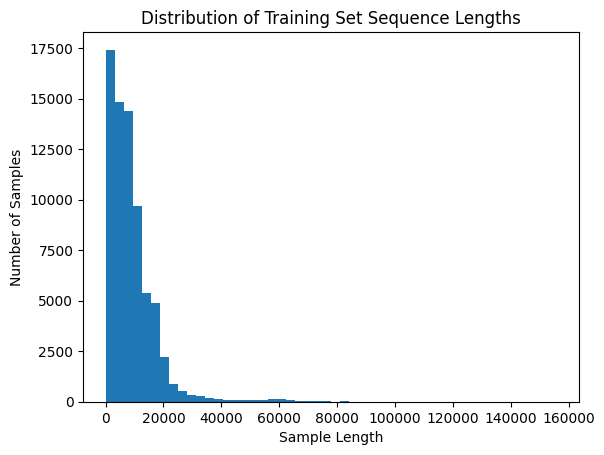

In [11]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called `dataset` with a column named 'bytecode'
ast_sequence_lengths = train_df['processed_sequence'].apply(lambda x: len(x.split())).tolist()

# Plot the histogram
plt.hist(ast_sequence_lengths, bins=50)
plt.xlabel('Sample Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Training Set Sequence Lengths')
plt.savefig('/content/drive/MyDrive/Practicum/Docs/training_ast_sequence_lengths.png')
plt.show()

In [7]:
import numpy as np

# Find the maximum length
max_length = max(ast_sequence_lengths)
print("Maximum Length:", max_length)

# Find the length at which 90% of the sample lengths are less than
sorted_lengths = sorted(ast_sequence_lengths)
percentile_95 = np.percentile(sorted_lengths, 95)
print("Length at 95th percentile:", percentile_95)

NameError: ignored

In [9]:
from keras.utils import pad_sequences

MSL = 21500

padded_sequences = pad_sequences(sequences, maxlen=MSL, padding='post', truncating='post')

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import pandas as pd
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Pad the sequences to a fixed length
labels = [0, 1, 2, 3, 4, 5]

def convertLabelListToArray(labelList):
    labelArrays = labelList.apply(lambda x: np.array(x.strip('[]').split(',')).astype(int))
    mlb = MultiLabelBinarizer(classes=labels)
    binaryLabels = mlb.fit_transform(labelArrays)
    return binaryLabels

binary_labels = convertLabelListToArray(train_df['labels'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
sequence_pd = pd.DataFrame(padded_sequences)
labels = pd.DataFrame(binary_labels)

print(sequence_pd.shape)
print(labels.shape)

(72001, 21500)
(72001, 6)


In [13]:
import h5py

hdf5_path = '/content/drive/MyDrive/Practicum/HDF5DataAst/training.h5'

# Save sequence_pd to an HDF5 dataset
sequence_pd.to_hdf(hdf5_path, key='sequence_pd', mode='w')

# Save labels to an HDF5 dataset
labels.to_hdf(hdf5_path, key='labels', mode='a')

In [5]:
# Check the keys of the HDF5 file to see what datasets are available
print(hdf5_file_training.keys())

<KeysViewHDF5 ['labels', 'sequence_pd']>


In [ ]:
!pip install --upgrade h5py pandas

In [4]:
import h5py

# Open the HDF5 file
hdf5_file = h5py.File('/content/drive/MyDrive/Practicum/HDF5Data/training.h5', 'r')

# Get the dataset
dataset = hdf5_file['data']
labels = hdf5_file['labels']

# Print the dimensions
print(dataset.shape)
print(labels.shape)

(79414, 24600)
(79414, 6)


In [5]:
import h5py

def print_hdf5_item(name, obj):
    print(f"Name: {name}")
    print(f"Type: {type(obj)}")

    if isinstance(obj, h5py.Group):
        print("---- Group Attributes ----")
        for key, value in obj.attrs.items():
            print(f"{key}: {value}")
    elif isinstance(obj, h5py.Dataset):
        print("---- Dataset Attributes ----")
        for key, value in obj.attrs.items():
            print(f"{key}: {value}")
        print("---- Data ----")
        print(obj[:])  # Print the data (you can remove this line if the dataset is large)

    print("")

# Open the HDF5 file
hdf5_path = '/content/drive/MyDrive/Practicum/HDF5DataAst/training.h5'
with h5py.File(hdf5_path, 'r') as hdf5_file:
    # Recursively visit all items in the file and print their details
    hdf5_file.visititems(print_hdf5_item)

Name: labels
Type: <class 'h5py._hl.group.Group'>
---- Group Attributes ----
CLASS: b'GROUP'
TITLE: Empty(dtype=dtype('S1'))
VERSION: b'1.0'
axis0_variety: b'regular'
axis1_variety: b'regular'
block0_items_variety: b'regular'
encoding: b'UTF-8'
errors: b'strict'
nblocks: 1
ndim: 2
pandas_type: b'frame'
pandas_version: b'0.15.2'

Name: labels/axis0
Type: <class 'h5py._hl.dataset.Dataset'>
---- Dataset Attributes ----
CLASS: b'ARRAY'
FLAVOR: b'numpy'
TITLE: Empty(dtype=dtype('S1'))
VERSION: b'2.4'
kind: b'integer'
name: b'N.'
transposed: 1
---- Data ----
[0 1 2 3 4 5]

Name: labels/axis1
Type: <class 'h5py._hl.dataset.Dataset'>
---- Dataset Attributes ----
CLASS: b'ARRAY'
FLAVOR: b'numpy'
TITLE: Empty(dtype=dtype('S1'))
VERSION: b'2.4'
kind: b'integer'
name: b'N.'
transposed: 1
---- Data ----
[    0     1     2 ... 71998 71999 72000]

Name: labels/block0_items
Type: <class 'h5py._hl.dataset.Dataset'>
---- Dataset Attributes ----
CLASS: b'ARRAY'
FLAVOR: b'numpy'
TITLE: Empty(dtype=dtype('